# Precipation Data with NCEI Tutorial

This notebook has been developed to access point-based (by weather station) precipation data in the Global Historical Climatology Network Daily (GHCND) dataset available by API in NCEI's Climate Data Online (CDO).  

You will first need to obtain a token which can be requested here: https://www.ncdc.noaa.gov/cdo-web/token (response is quick, if not immediate)

In [2]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import os

In [4]:
if "NCDC_CDO_TOKEN" in os.environ.keys():
    api_token = os.environ['NCDC_CDO_TOKEN']
else:
    api_token = "your_token_here"

your_token_here


## Exploring the Datasets

There are a variety of useful datasets in CDO, let's take a look.  Alternatively, you can explore the datasets at https://www.ncei.noaa.gov/cdo-web/datasets.

In [3]:
# First let's get a list of all datasets using the Base URL for the datasets endpoint
url = "https://www.ncei.noaa.gov/cdo-web/api/v2/datasets"

In [5]:
# Define the headers with the token
headers = {
    'token': api_token
}

# Make the request to the API
response = requests.get(url, headers=headers)

In [6]:
# Define the headers with the token
headers = {
    'token': api_token
}

# Make the request to the API
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Ensure the 'results' key exists in the response
    if 'results' in data:
        datasets = data['results']
        
        # Print the available datasets
        for dataset in datasets:
            print(f"ID: {dataset.get('id', 'N/A')}")
            print(f"Name: {dataset.get('name', 'N/A')}")
            print(f"Description: {dataset.get('description', 'No description available')}")
            print(f"Min Date: {dataset.get('mindate', 'N/A')}")
            print(f"Max Date: {dataset.get('maxdate', 'N/A')}")
            print(f"Coverage: {dataset.get('coverage', 'N/A')}")
            print("-----------")
    else:
        print("No datasets found in the response.")
else:
    print(f"Failed to retrieve data: {response.status_code}, {response.text}")

Failed to retrieve data: 400, {"status" : "400", "message" : "The token parameter provided is not valid."}


### Let's look closer at the variables in GHCND (Global Historical Climatology Network-Daily)

Besides precipitation, what else is available in the GHCND?  Full documentation on GHCND is also available at https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf.

In [7]:
# Example dataset ID (replace with the dataset ID you want to explore)
dataset_id = "GHCND"  # Replace with actual dataset ID

# Base URL for the datatypes endpoint
datatypes_url = f"https://www.ncei.noaa.gov/cdo-web/api/v2/datatypes"

# Define the parameters to filter by the dataset ID
params = {
    'datasetid': dataset_id
}

# Make the request to the API to get datatypes for the specified dataset
response = requests.get(datatypes_url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    datatypes = response.json().get('results', [])
    
    # Print available datatypes for the specified dataset
    for datatype in datatypes:
        print(f"ID: {datatype.get('id', 'N/A')} - Name: {datatype.get('name', 'N/A')} - Description: {datatype.get('description', 'No description available')}")
else:
    print(f"Failed to retrieve datatypes: {response.status_code}, {response.text}")

Failed to retrieve datatypes: 400, {"status" : "400", "message" : "The token parameter provided is not valid."}


### What Geographic Categories are available in the GHCND?

In [68]:
# Base URL for the locationcategories endpoint
locationcategories_url = f"https://www.ncei.noaa.gov/cdo-web/api/v2/locationcategories"

# Define the parameters to filter by the dataset ID
params = {
    'datasetid': dataset_id
}

# Make the request to the API to get location categories for the specified dataset
response = requests.get(locationcategories_url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    locationcategories = response.json().get('results', [])
    
    # Print available location categories for the specified dataset
    for locationcategory in locationcategories:
        print(f"ID: {locationcategory.get('id', 'N/A')} - Name: {locationcategory.get('name', 'N/A')} - Description: {locationcategory.get('description', 'No description available')}")
else:
    print(f"Failed to retrieve location categories: {response.status_code}, {response.text}")

ID: CITY - Name: City - Description: No description available
ID: CLIM_DIV - Name: Climate Division - Description: No description available
ID: CLIM_REG - Name: Climate Region - Description: No description available
ID: CNTRY - Name: Country - Description: No description available
ID: CNTY - Name: County - Description: No description available
ID: HYD_ACC - Name: Hydrologic Accounting Unit - Description: No description available
ID: HYD_CAT - Name: Hydrologic Cataloging Unit - Description: No description available
ID: HYD_REG - Name: Hydrologic Region - Description: No description available
ID: HYD_SUB - Name: Hydrologic Subregion - Description: No description available
ID: ST - Name: State - Description: No description available
ID: US_TERR - Name: US Territory - Description: No description available
ID: ZIP - Name: Zip Code - Description: No description available


### Gathering Data

Let's pull some precipipation (PRCP) data for the zip codes covered by the longitudinal survey.  First, let's loop through all zip codes included in the survey administration area.  This can create problems for the server some times, so we are batching the zip codes and putting a 1 second delay between requests.  It may take a while to download the data.

In [69]:
# Base URL for the data endpoint
base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"

# Define the headers with the token
headers = {
    'token': api_token
}

# List of zip codes
zip_codes = [92243]

# Define the parameters
params = {
    'datasetid': 'GHCND',
    'startdate': '2024-01-01',
    'enddate': '2024-04-30',
    'limit': 1000,
    'datatypeid': ['PRCP'],
    'units': 'metric'
}

# List to store all the data entries
all_data = []

# Loop through each ZIP code and make the API request
batch_size = 5  # Number of requests per second allowed
for i in range(0, len(zip_codes), batch_size):
    batch = zip_codes[i:i + batch_size]
    for zip_code in batch:
        params['locationid'] = f'ZIP:{zip_code}'
        response = requests.get(base_url, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json().get('results', [])
            for entry in data:
                entry['zip_code'] = zip_code  # Add ZIP code to each entry
                all_data.append(entry)
        else:
            print(f"Failed to retrieve data for ZIP code {zip_code}: {response.status_code}")
    
    # Delay after each batch
    time.sleep(1)  # Sleep for 1 second to ensure we don't exceed 5 requests per second

# Convert the collected data to a DataFrame
df = pd.DataFrame(all_data)

# Display the first few rows of the DataFrame
df.head()

,date,datatype,station,attributes,value,zip_code
0,2024-01-01T00:00:00,PRCP,GHCND:USC00042713,",,7,0800",0.0,92243
1,2024-01-01T00:00:00,PRCP,GHCND:USW00023199,",,W,",0.0,92243
2,2024-01-02T00:00:00,PRCP,GHCND:USC00042713,",,7,0800",0.0,92243
3,2024-01-03T00:00:00,PRCP,GHCND:USC00042713,",,7,0800",0.0,92243
4,2024-01-03T00:00:00,PRCP,GHCND:USW00023199,",,W,",0.3,92243


## Zip Codes

Now you try it using the zip code for the survey area in Southern California.

In [70]:
# List of zip codes
zip_codes = [
    90001, 90002, 90003, 90004, 90005, 90006, 90210, 90211, 90212, 90230, 90232, 
    91701, 91708, 91709, 91710, 91730, 91737, 91739, 91743, 91759, 91901, 91902, 
    91905, 91910, 91911, 91913, 92007, 92008, 92009, 92010, 92011, 92220, 92222, 
    92223, 92225, 92227, 92230, 92231, 92232, 92233, 92234, 92236, 92240, 92241, 
    92243, 92244, 92249, 92250, 92251, 92252, 92253, 92258, 92301, 92307, 92602, 
    92603, 92604, 92606, 92610, 92612, 92614, 92617, 92618, 92620, 92624, 93001, 
    93003, 93004, 93010, 93012, 93013, 93015, 93021, 93030, 93033, 93036, 93101, 
    93105, 93110, 93201, 93202, 93203, 93205, 93206, 93207, 93208, 93212, 93215, 
    93216, 93219, 93221, 93222, 93223, 93224, 93225, 93226, 93227, 93230, 93232, 
    93235, 93237, 93238, 93240, 93245, 93247, 93401, 93402, 93405, 93420, 93422, 
    93424, 93426, 93427, 93428, 93430, 93432, 93433, 93436, 93454, 93460, 93463, 
    93513, 93514, 93515, 93526, 93541, 93545, 93549, 93601, 93602, 93606, 93607, 
    93608, 93609, 93610, 93611, 93612, 93616, 93619, 93620, 93623, 93635, 93636, 
    93637, 93638, 93639, 93661, 93665, 93901, 93905, 93906, 93907, 93908, 93920, 
    93923, 93924, 93925, 93927, 95023, 95024, 95043, 95301, 95303, 95306, 95312, 
    95315, 95317, 95322, 95324, 95333, 95338, 95345
]

### Use the code in Gather Data to pull data for all the zip codes  for the survey area

In [71]:
#copy and paste from cell "Gathering Data" and make the necessary changes


### How many stations per zip code?

In [72]:
stations_count_by_zip = df.groupby('zip_code')['station'].nunique().reset_index()

# Rename columns for clarity
stations_count_by_zip.columns = ['ZIP_CODE', 'STATION_COUNT']

# Display the result
stations_count_by_zip

,ZIP_CODE,STATION_COUNT
0,92243,2


### Where are stations located (by zip code)?

In [73]:
stations_by_zip = df.groupby('zip_code')['station'].agg(list).reset_index()
stations_by_zip

,zip_code,station
0,92243,"[GHCND:USC00042713, GHCND:USW00023199, GHCND:U..."


### Visualizing the data

This will get a little messy with 74 zip codes, but it should show general precipitation trends for this geographic area.

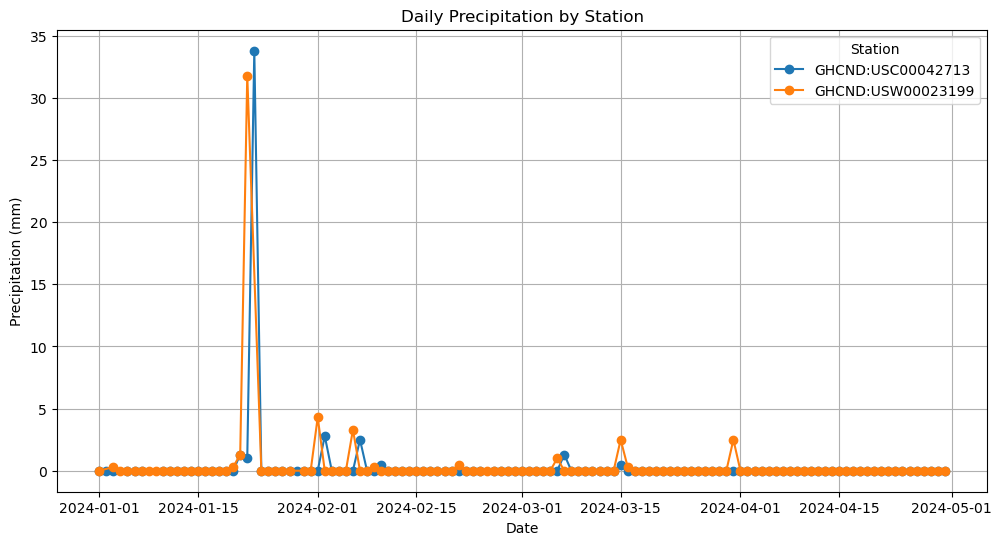

In [74]:
# Convert DATE to datetime format
df['date'] = pd.to_datetime(df['date'])

# Plotting
plt.figure(figsize=(12, 6))
for station in df['station'].unique():
    station_data = df[df['station'] == station]
    plt.plot(station_data['date'], station_data['value'], marker='o', label=station)

plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation by Station')
plt.legend(title='Station')
plt.grid(True)
plt.show()

## Closing

The GHCND is one way to collect point-based precipation amounts, and other weather variables, as recorded daily by weather stations.  Obviously, a certain amount of cleaning is still necessary (perhaps selecting one station per zip code; alternatively, one couple identify stations by zip and pull data by station), but this data might be useful for long-term case studies.  In this case, we can see actual precipitation amounts experienced by survey respondents.